In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interact

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import bisect
from scipy.special import erf
import json
from functools import partial
class Foo: pass
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
config = Foo()
orders = [4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32]
#elms = [4, 8, 12, 16, 20, 24, 28, 32]
elms = [4, 8, 12, 16, 24, 32, 48, 64, 96, 128]
config.names = []
for order in orders:
    for elm in elms:
        if order * elm >= 64 and order * elm <= 512:
            config.names.append("cnv_o{:d}_e{:d}/cnv_o{:d}_e{:d}".format(order, elm, order, elm))       

In [3]:
def read_outfile(f):
    ans = {"time": 0.0, "gflops": 0.0, "gibs": 0.0}
    num_proc = 1
    for line in f.readlines():
        if "Number of processors:" in line:
            num_proc = int(line.split()[3])
        if "total time" in line:
            ans["time"] = float(line.split()[2])*num_proc
        if "Total    " in line:
            ans["gflops"] = float(line.split()[1])
            ans["gibs"] = float(line.split()[3])
    if ans["time"] < 0.0001:
        print("output file didn't complete: {}".format(f.name))
    ans["gflops"]  = ans["gflops"]  * ans["time"] 
    ans["gibs"]  = ans["gibs"]  * ans["time"]
    return ans

In [4]:
config.arch_end = "maxhutch#alpha-admin/~/pub/ConvergeRTI_Shaheen/"
from globussh import ls
from os.path import join
times_shaheen = {}
for name in config.names:            
    sol = {"time": 0.0, "gflops": 0.0, "gibs": 0.0}
    try:
        out_files = ls(join(config.arch_end, name + "*.output"))
    except:
        print("{:} is skipped".format(name))
        continue
    paths = [join(*(name.split("/")[0:-1] + [of,])) for of in out_files]
    if len(paths) != 8:
        print("{:} is incomplete".format(name))
        continue
    with glopen_many(paths, mode='r', endpoint=config.arch_end) as fs:
        for f in fs:
            part = read_outfile(f)
            for k in part:
                sol[k] += part[k]
    with glopen(
                "{:s}.json".format(name), mode='r',
                endpoint = config.arch_end,
                ) as f:
        p = json.load(f)
    for k in sol:
        times_shaheen[p['order'], p['shape_mesh'][0], k] = sol[k]

cnv_o4_e16/cnv_o4_e16 is skipped
cnv_o4_e24/cnv_o4_e24 is skipped
cnv_o4_e48/cnv_o4_e48 is skipped
cnv_o6_e12/cnv_o6_e12 is skipped
cnv_o6_e16/cnv_o6_e16 is skipped
cnv_o6_e24/cnv_o6_e24 is skipped
cnv_o6_e48/cnv_o6_e48 is skipped
cnv_o8_e8/cnv_o8_e8 is skipped
cnv_o8_e12/cnv_o8_e12 is skipped
cnv_o8_e24/cnv_o8_e24 is skipped
cnv_o10_e8/cnv_o10_e8 is skipped
cnv_o10_e12/cnv_o10_e12 is skipped
cnv_o10_e24/cnv_o10_e24 is skipped
cnv_o12_e8/cnv_o12_e8 is skipped
cnv_o12_e12/cnv_o12_e12 is skipped
cnv_o12_e24/cnv_o12_e24 is skipped
cnv_o14_e8/cnv_o14_e8 is skipped
cnv_o14_e12/cnv_o14_e12 is skipped
cnv_o16_e4/cnv_o16_e4 is skipped
cnv_o16_e12/cnv_o16_e12 is skipped
cnv_o18_e4/cnv_o18_e4 is skipped
cnv_o18_e8/cnv_o18_e8 is skipped
cnv_o18_e12/cnv_o18_e12 is skipped
cnv_o18_e16/cnv_o18_e16 is skipped
cnv_o18_e24/cnv_o18_e24 is skipped
cnv_o20_e4/cnv_o20_e4 is skipped
cnv_o20_e8/cnv_o20_e8 is skipped
cnv_o20_e12/cnv_o20_e12 is skipped
cnv_o20_e16/cnv_o20_e16 is skipped
cnv_o20_e24/cnv_o20_e24

In [5]:
def make_plots(times, bw):
    table = CachedSlict(times)
    fig, ax = plt.subplots(1)
    ax.loglog([4,32],[10**4,(8**4)*10**4], 'k-')
    for order in orders:
        ax.loglog(table[order,:,'time'].keys(), table[order,:,'time'].values(), 'x--', label="Order={}".format(order))
    plt.xlabel('Number of elements on x-axis')
    plt.ylabel('Total core hours')
    plt.legend()
    
    fig, ax = plt.subplots(1)
    for order in orders:
        ax.loglog(table[order,:,'gflops'].keys(), table[order,:,'gflops'].values(), 'x--', label="Order={}".format(order))
    plt.xlabel('Number of elements on x-axis')
    plt.ylabel('GFLOP')
    plt.legend()

    fig, ax = plt.subplots(1)
    for order in orders:
        ax.plot(table[order,:,'gflops'].keys(), 
                np.array(table[order,:,'gflops'].values())/np.array(table[order,:,'time'].values()), 
                'x--', label="Order={}".format(order))
    plt.xlabel('Number of elements on x-axis')
    plt.ylabel('GFLOPs / core')
    plt.legend()

    fig, ax = plt.subplots(1)
    ax.axhline(bw)
    for order in orders:
        ax.plot(table[order,:,'gibs'].keys(), 
                np.array(table[order,:,'gibs'].values())/np.array(table[order,:,'time'].values()), 
                'x--', label="Order={}".format(order))
    plt.xlabel('Number of elements on x-axis')
    plt.ylabel('GiB/s / core')
    plt.ylim(0,int(bw)+1)
    plt.legend()

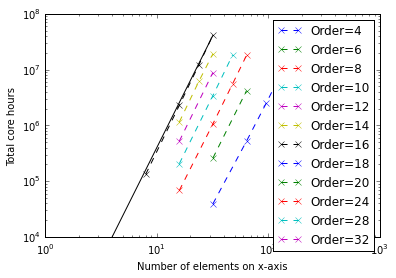

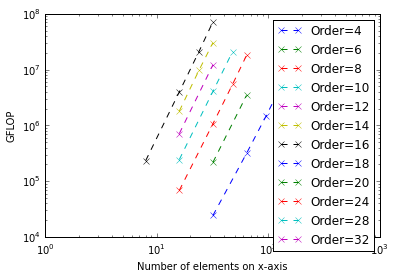

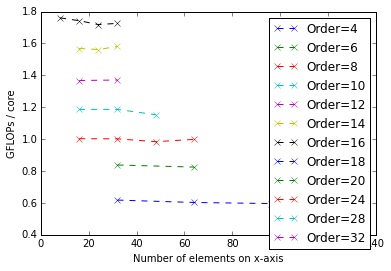

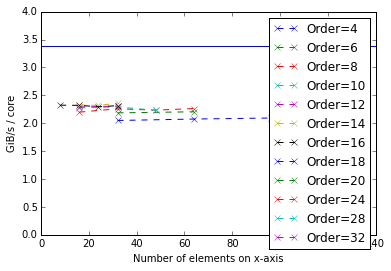

In [6]:
make_plots(times_shaheen, 108./32.)

In [7]:
#config.arch_end = "maxhutch#alpha-admin/~/pub/ConvergeRTI/"
config.arch_end = "alcf#dtn_mira/projects/HighAspectRTI/experiments/ConvergeRTI/"
from globussh import ls
from os.path import join
times_mira = {}
for name in config.names:    
    sol = {"time": 0.0, "gflops": 0.0, "gibs": 0.0}
    parts = name.rpartition("/")
    #out_files = ls(join(config.arch_end, parts[0], "stdout", parts[2] + "*.output"))
    try:
        out_files = ls(join(config.arch_end, name + "*.output"))
    except:
        print("{:} is skipped".format(name))
        continue
    paths = [join(*(name.split("/")[0:-1] + [of,])) for of in out_files]
    if len(paths) != 8:
        print("{:} is incomplete".format(name))
        continue
    with glopen_many(paths, mode='r', endpoint=config.arch_end) as fs:
        for f in fs:
            part = read_outfile(f)
            for k in part:
                sol[k] += part[k]
    with glopen(
                "{:s}.json".format(name), mode='r',
                endpoint = config.arch_end,
                ) as f:
        p = json.load(f)
    for k in sol:
        times_mira[p['order'], p['shape_mesh'][0], k] = sol[k]
    if p['order'] <= 24:
        times_mira[p['order'], p['shape_mesh'][0], 'time'] /= 4
    else:
        times_mira[p['order'], p['shape_mesh'][0], 'time'] /= 2

cnv_o4_e24/cnv_o4_e24 is skipped
cnv_o4_e96/cnv_o4_e96 is skipped
cnv_o4_e128/cnv_o4_e128 is skipped
cnv_o6_e12/cnv_o6_e12 is skipped
cnv_o6_e24/cnv_o6_e24 is skipped
cnv_o6_e48/cnv_o6_e48 is skipped
cnv_o6_e64/cnv_o6_e64 is skipped
cnv_o8_e12/cnv_o8_e12 is skipped
cnv_o8_e48/cnv_o8_e48 is skipped
cnv_o8_e64/cnv_o8_e64 is skipped
cnv_o10_e12/cnv_o10_e12 is skipped
cnv_o10_e32/cnv_o10_e32 is skipped
cnv_o10_e48/cnv_o10_e48 is skipped
cnv_o12_e12/cnv_o12_e12 is skipped
cnv_o12_e24/cnv_o12_e24 is skipped
cnv_o12_e32/cnv_o12_e32 is skipped
cnv_o14_e24/cnv_o14_e24 is skipped
cnv_o14_e32/cnv_o14_e32 is skipped
cnv_o16_e24/cnv_o16_e24 is skipped
cnv_o18_e16/cnv_o18_e16 is skipped
cnv_o18_e24/cnv_o18_e24 is skipped
cnv_o20_e16/cnv_o20_e16 is skipped
cnv_o20_e24/cnv_o20_e24 is skipped
cnv_o24_e12/cnv_o24_e12 is skipped
cnv_o24_e16/cnv_o24_e16 is skipped
cnv_o28_e12/cnv_o28_e12 is skipped
cnv_o28_e16/cnv_o28_e16 is skipped
cnv_o32_e12/cnv_o32_e12 is skipped
cnv_o32_e16/cnv_o32_e16 is skipped


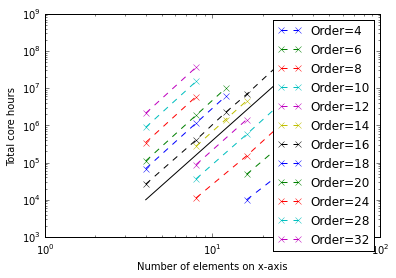

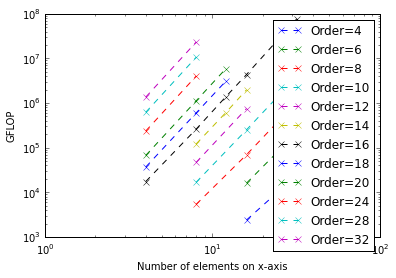

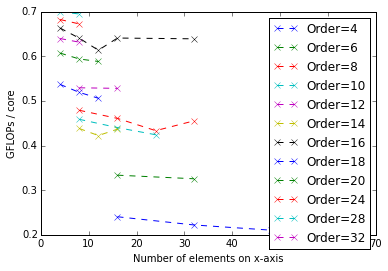

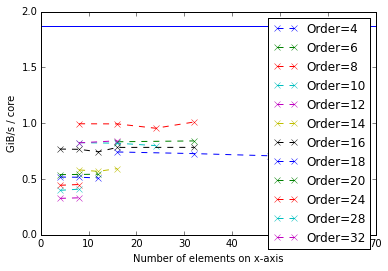

In [8]:
make_plots(times_mira, 30./16.)

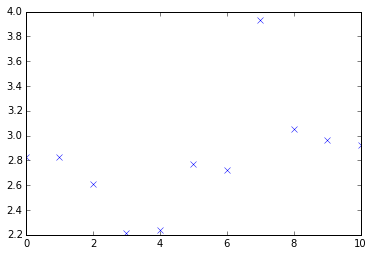

In [9]:
table_mira = CachedSlict(times_mira)
table_shaheen = CachedSlict(times_shaheen)
plt.plot([table_mira[k[0],k[1],'time'] / table_shaheen[k[0],k[1],'time'] for k in table_mira[:,:,'time'] if k in table_shaheen[:,:,'time']], 'x')

In [10]:
import pickle
with open("times_shaheen.p", "wb") as f:
    pickle.dump(times_shaheen, f)
with open("times_mira.p", "wb") as f:
    pickle.dump(times_mira, f)    

In [11]:
import pickle
with open("times_shaheen.p", "rb") as f:
    times_shaheen = pickle.load(f)
with open("times_mira.p", "rb") as f:
    times_mira = pickle.load(f)